# Modeling
- This notebook will focus on building models that predict fradulent transactions
- We will deal with class imbalance by upsampling the minority classes with SMOTE, and downsampling the majority class.
- We will look at the performance of 8 ML approaches. From these, we will select a ML approach and perform hyperparameter tuning.
- Finally, we will assess the performance of the optimized model by 1) visualizing the confusion matrix, 2) plotting the precision-recall curve and exmaining AUPRC scores, 3) examining the f1-macro score.
- NOTE: As a rule of thumb, you should use the precision recall (PR) curve whenever the positive class is rare (say I want to predict whether a number is 5 (positive case) or not 5 (negative case), and only 10% of the sample are actually 5)

- I  also use f1-macro as the evaluation metric:
    - A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric.
    - In a multi-class/binary classification setup, macro-average is preferable if you suspect there might be class imbalance (i.e you may have many more examples of one class than of other classes) AND you care as much, if not more about the minority class than the majority class. 
    - Macro-average will treat both classes as "equally important", despite the majority of the test sample belonging to the (less interesting) majority class. 
    - In contrast, if I do micro-averaging, or weighted averging, I am accounting for the sample size of the majority and minority classes: i.e., if the model performs poorly in predicting test samples in the minority class, it might not matter as much to the `overall performance` of the model. I care more about how well the model predicts the majority class.

## General Workflow
- Understand the problem
- Exploratory Data Analysis
- Clean and reformat data
- Feature engineering to create a dataset for machine learning
- Compare several machine learning models and select one
- Optimize the selected model
- Investigate model predictions and draw conclusions

In [1]:
'''data'''
import pandas as pd
import numpy as np

'''common'''
from pathlib import Path
import pickle
import os
import itertools

'''Typing'''
from typing import Dict, Union

'''sklearn'''
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score, cross_val_predict, 
    train_test_split,
    cross_validate,
    RandomizedSearchCV,GridSearchCV)
from sklearn.preprocessing import StandardScaler

'''imblearn'''
from imblearn.pipeline import Pipeline as imb_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

'''feature engine'''
from feature_engine.selection import DropConstantFeatures
from feature_engine.outliers import OutlierTrimmer
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.selection import DropFeatures

'''models'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier


'''metrics'''
from sklearn.metrics import (
    confusion_matrix,
    precision_score, recall_score, f1_score, 
    precision_recall_curve, average_precision_score,
    roc_curve, roc_auc_score
)

'''visualization'''
import seaborn as sns
import matplotlib.pyplot as plt

'''warnings'''
import warnings 
from sklearn.exceptions import ConvergenceWarning

# Filter out warnings from models
warnings.filterwarnings("ignore", category = ConvergenceWarning)
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)

In [2]:
# Set working directory 
try: INIT_RUN
except NameError:
    os.chdir(os.path.dirname(os.getcwd()))
    INIT_RUN=True

In [3]:
# Customized modules
import src.data_manager as dm
import src.processing as pp

In [4]:
%reload_ext autoreload
%autoreload 2

## Config

In [5]:
# Scoring method for models
SCORING = "f1_macro" #"average_precision" 
# Random seed
RANDOM_STATE = 10
# Test size
TEST_SIZE = 0.2
# variables to be standardize
STD_VARS = ["Amount"]
# Selected features from FeatureWiz
SELECTED_FEATURES=['V14', 'V8', 'V13', 'V7', 'Amount', 'V19', 'V23', 'V6', 'V26', 'V25', 'V28']

## Custom Estimator

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

# This custom step saves the column names of its input dataframe as a binary .pkl file
class save_col_names(BaseEstimator, TransformerMixin):
    """
    Constructor

    Args:
        step_name: the name of the step prior to "save_col_names". I want to save the column names of that step

    Returns:
        void
    """

    def __init__(self, step_name:str):
        self.step_name = step_name 


    def fit(self, X,
            y=None):  # need to have y as argument to make class compatible with sklearn pipeline
        """ Fit

        Args:
            X (DataFrame): a input dataframe of features to train the transformer
            y (DataFrame): a input Series of response variable to train the transformer (optional)

        Returns:
            self
        """

        return self

    def transform(self, X):
        """ Transform

        Args:
            X (DataFrame): a input dataframe of features to be transformed

        """

        # Make a copy of the input dataframe
        # so we won't overwrite the original Dataframe that was passed as argument
        X = X.copy()
        
        # Get feature names
        feature_names = X.columns.tolist
        
        # Save as pickle
        with open(Path('outputs',f'{self.step_name}_feature_names.pkl'), 'wb') as f:
            pickle.dump(feature_names, f)

        return X

## Import 

In [7]:
raw = dm.load_data(Path("data", "raw"), "creditcard.csv")

In [8]:
raw.shape

(284807, 31)

Include only features selected by FeatureWiz

In [9]:
# Get raw dataframe with selected features from FeatureWiz
df = raw.loc[:,SELECTED_FEATURES +["Class"]]

In [10]:
df.shape

(284807, 12)

## Train test split
- Create test (holdout set) to evaluate the final, optimzed model
- The train set would be further divided into tr and val sets for training and validating models
- Stratify by class so both train and test sets retains the class distribution

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("Class", axis="columns"),
    df.Class,
    test_size = TEST_SIZE,
    random_state= RANDOM_STATE,
    stratify = df["Class"]
)

In [12]:
# Save the test set
X_test.to_csv(Path("data","test","X_test.csv"))
y_test.to_csv(Path("data","test","y_test.csv"))

In [13]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((227845, 11), (227845,), (56962, 11), (56962,))

## Data pipeline
- Drop features with near zero variance
- Standardize `Amount` and `Time`
- Upsample the minority class using SMOTE, and downsample the majority class using RandomUnderSampler
- Modeling

In [14]:
# Create pipeline
data_pipeline = imb_pipeline([
 
     # === drop qusai-constant variables === #
     # drop variables with any level that appears in 0.75 of observations
     ('drop_nzv', DropConstantFeatures(tol=0.75)),
    
     # === save feature names (of the df from the drop_nzv step) ===
     ('save_feature_names', save_col_names(step_name='feature_selection')),
        
    # === standardization === #
    ('feature_scaling', SklearnTransformerWrapper(transformer = StandardScaler(),
                                    variables = STD_VARS)),
    # === oversampling === # 
    # upsample the minority classes to have 0.1 of the majority class
    ('oversampling', SMOTE(sampling_strategy=0.1,
                           random_state=RANDOM_STATE)),
    # === undersampling ==== # 
    # undersample the majority class to have 2x of minority class 
    ('undersampling', RandomUnderSampler(sampling_strategy= 0.5,
                                         random_state=RANDOM_STATE)),
    
 ])

In [15]:
# Fit and transform X_train and y_train
# Use fit_resample() since my last step in the pipeline are estimators from imblearn
x_tr_processed, y_tr_processed = data_pipeline.fit_resample(X_train, y_train) 

## Save processed data

In [16]:
x_tr_processed.to_pickle(Path("data","processed","x_tr_processed_final.pkl"))
y_tr_processed.to_pickle(Path("data","processed","y_tr_processed_final.pkl"))

## Modeling

In [17]:
# Define function to compute cv_scores for a user-specified model

def evaluate_model(X,y,clf,cv,scoring):
    
    # Create pipeline
    data_pipeline = imb_pipeline([
 
     # === drop qusai-constant variables === #
     # drop variables with any level that appears in 0.75 of observations
     ('drop_nzv', DropConstantFeatures(tol=0.75)),
    
     # === save feature names (of the df from the drop_nzv step) ===
     ('save_feature_names', save_col_names(step_name='feature_selection')),
        
    # === standardization === #
    ('feature_scaling', SklearnTransformerWrapper(transformer = StandardScaler(),
                                    variables = STD_VARS)),
    # === oversampling === # 
    # upsample the minority classes to have 0.1 of the majority class
    ('oversampling', SMOTE(sampling_strategy=0.1,
                           random_state=RANDOM_STATE)),
        
    # === undersampling ==== # 
    # undersample the majority class to have 2x of minority class
    ('undersampling', RandomUnderSampler(sampling_strategy= 0.5,
                                         random_state=RANDOM_STATE)),
    
    # === model === #
    ('model', clf)    
    
 ])
    
    # Compute cv scores
    cv_scores = cross_val_score(estimator = data_pipeline,
                                X = X,
                                y = y,
                                scoring = scoring,
                                cv = cv,
                                n_jobs=1)
    
    return cv_scores

In [18]:
# Define the 5-foldCV iterator
skf = StratifiedKFold(
    n_splits = 5,
    shuffle = True,
    random_state = RANDOM_STATE
)
skf.get_n_splits()

5

In [19]:
# Define a dict of models
models = {"dummy": DummyClassifier(random_state = RANDOM_STATE),
          "SGD" : SGDClassifier(random_state = RANDOM_STATE),
          "Random Forest": RandomForestClassifier(n_estimators= 100, random_state = RANDOM_STATE),
          "SVC" : LinearSVC(random_state = RANDOM_STATE),
          "Naive Bayes": GaussianNB(),
          "KNN": KNeighborsClassifier(),
          "lightgbm": LGBMClassifier(random_state = RANDOM_STATE),
         }

In [20]:
# Train each model in the models dict, and then populate a dataframe with scores

res = {} # empty results dictionary that will contain cv_scores for each model

for k,v in models.items():
    cv_scores = evaluate_model(X = X_train,
                   y = y_train,
                   clf = v,
                   cv = skf,
                   scoring = SCORING
                  )
    # update results dictionary
    res.update({k:cv_scores}) # .update(): append a HashMap 
    
    # print mean and sd cv scores of each model
    print(f"{k}")
    print(f"mean {SCORING}: {np.round(np.mean(cv_scores),2)}")
    print(f"stdev {SCORING}: {np.round(np.std(cv_scores),2)}")
    print()

dummy
mean f1_macro: 0.5
stdev f1_macro: 0.0

SGD
mean f1_macro: 0.59
stdev f1_macro: 0.01

Random Forest
mean f1_macro: 0.84
stdev f1_macro: 0.01

SVC
mean f1_macro: 0.59
stdev f1_macro: 0.01

Naive Bayes
mean f1_macro: 0.54
stdev f1_macro: 0.0

KNN
mean f1_macro: 0.59
stdev f1_macro: 0.0

lightgbm
mean f1_macro: 0.73
stdev f1_macro: 0.01



In [21]:
res

{'dummy': array([0.49957171, 0.49956622, 0.49956622, 0.49956622, 0.49956622]),
 'SGD': array([0.58135479, 0.61264287, 0.57280911, 0.58727263, 0.59297317]),
 'Random Forest': array([0.83779584, 0.83857006, 0.82449373, 0.84747967, 0.8422281 ]),
 'SVC': array([0.59432126, 0.60517077, 0.59813235, 0.5825198 , 0.58978705]),
 'Naive Bayes': array([0.53772495, 0.53920683, 0.54003855, 0.54092948, 0.53862337]),
 'KNN': array([0.5923686 , 0.58718858, 0.58981505, 0.58566576, 0.59700965]),
 'lightgbm': array([0.71148698, 0.72996034, 0.73155786, 0.73464178, 0.74930682])}

**Comment: according to the mean CV score (f1 macro), xgboost and Random Forest has the best performance. We will fine-tune our "short list" of promising models. Then I will select the best one and evaluating it with the hold-out (test) set.**

In [22]:
# Create results dataframe
df_res = pd.DataFrame.from_dict(res)
df_res.head()

,dummy,SGD,Random Forest,SVC,Naive Bayes,KNN,lightgbm
0,0.499572,0.581355,0.837796,0.594321,0.537725,0.592369,0.711487
1,0.499566,0.612643,0.838570,0.605171,0.539207,0.587189,0.729960
2,0.499566,0.572809,0.824494,0.598132,0.540039,0.589815,0.731558
3,0.499566,0.587273,0.847480,0.582520,0.540929,0.585666,0.734642
4,0.499566,0.592973,0.842228,0.589787,0.538623,0.597010,0.749307


### Visualize the CV scores from each model

Text(0.5, 0, 'CV average f1_macro')

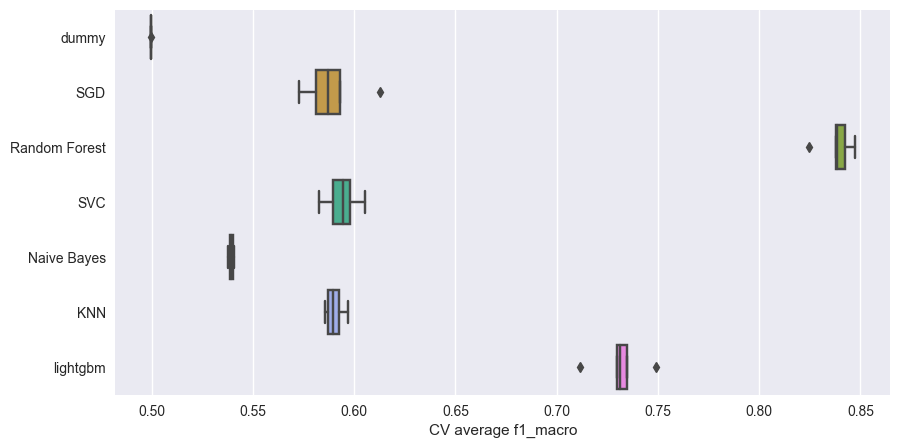

In [23]:
# styles
plt.style.use("seaborn")
plt.rcParams["font.size"]=16

# plotting df
df_plot = df_res.unstack().to_frame()

# Bar Plot
fig = plt.figure(figsize=(10,5))
sns.boxplot(
    y = df_plot.index.get_level_values(0),
    x = df_plot[0])

plt.xlabel(f"CV average {SCORING}")

## Tuning the Random Forest model
- Use GridSearchCV to hone in on a set of optimal hyperparameters
- I will try sets of hyparameters that differ slightly from the default value (which yielded mean CV score of 0.84 f1-macro)

In [24]:
# Create pipeline
rf_pipeline = imb_pipeline([

 # === drop qusai-constant variables === #
 # drop variables with any level that appears in X of observations
 ('drop_nzv', DropConstantFeatures(tol=0.75)),

 # === save feature names (of the df from the drop_nzv step) ===
 ('save_feature_names', save_col_names(step_name='feature_selection')),
    
# === standardization === #
('feature_scaling', SklearnTransformerWrapper(transformer = StandardScaler(),
                                variables = STD_VARS)),
# === oversampling === # 
# upsample the minority classes to have 0.1 of the majority class
('oversampling', SMOTE(sampling_strategy=0.1,
                       random_state=RANDOM_STATE)),
    
# === undersampling ==== # 
# undersample the majority class to have 2x of minority class
('undersampling', RandomUnderSampler(sampling_strategy= 0.5,
                                     random_state=RANDOM_STATE)),

# === model === #
 ('clf',  RandomForestClassifier(random_state= RANDOM_STATE))
])

In [25]:
# parameter grid
param_grid = {
         
    # classifier parameters 
    "clf__max_features": ["sqrt","log2"],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_split": [2,5,10],
    "clf__max_samples":[None, 0.05, 0.1]
}

In [26]:
rf_grid_search = GridSearchCV(estimator = rf_pipeline, 
                           param_grid = param_grid, 
                           cv = skf, 
                           scoring=SCORING,
                           verbose =1, # show the process
                           n_jobs = -1)  # n_jobs = -1 means use all processors

In [27]:
# fit model
rf_grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
             estimator=Pipeline(steps=[('drop_nzv',
                                        DropConstantFeatures(tol=0.75)),
                                       ('save_feature_names',
                                        save_col_names(step_name='feature_selection')),
                                       ('feature_scaling',
                                        SklearnTransformerWrapper(transformer=StandardScaler(),
                                                                  variables=['Amount'])),
                                       ('oversampling',
                                        SMOTE(random_state=10,
                                              sampling_strategy=0.1)),
                                       ('undersampling',
                                        RandomUnderSampler(random_state=10,
                                                           sampling_strategy=0.5)),
                                       ('clf',
                                        RandomForestClassifier(random_state=10))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [None, 10, 20],
                         'clf__max_features': ['sqrt', 'log2'],
                         'clf__max_samples': [None, 0.05, 0.1],
                         'clf__min_samples_split': [2, 5, 10]},
             scoring='f1_macro', verbose=1)

In [28]:
# Let's take a look at the optimal parameters
rf_grid_search.best_params_

{'clf__max_depth': None,
 'clf__max_features': 'sqrt',
 'clf__max_samples': None,
 'clf__min_samples_split': 2}

In [29]:
# What is the score of the model with the optimal parameter?
print(f"The optimal model has {SCORING} of {rf_grid_search.best_score_}")

The optimal model has f1_macro of 0.8381134804104736


In [30]:
# Persist the optimal pipeline (NOTE: the estimator of the grid_search object is a pipeline)
rf_grid_search_best_pipeline = rf_grid_search.best_estimator_

# Save as pickle
with open(Path('outputs','trained_models','rf_grid_search_best_pipeline.pkl'), 'wb') as f:
    pickle.dump(rf_grid_search_best_pipeline, f)

## Tuning lightgbm

In [31]:
# Create pipeline
gbm_pipeline = imb_pipeline([

 # === drop qusai-constant variables === #
 # drop variables with any level that appears in X of observations
 ('drop_nzv', DropConstantFeatures(tol=0.75)),

 # === save feature names (of the df from the drop_nzv step) ===
 ('save_feature_names', save_col_names(step_name='feature_selection')),
    
# === standardization === #
('feature_scaling', SklearnTransformerWrapper(transformer = StandardScaler(),
                                variables = STD_VARS)),
# === oversampling === # 
# upsample the minority classes to have 0.1 of the majority class
('oversampling', SMOTE(sampling_strategy=0.1,
                       random_state=RANDOM_STATE)),
    
# === undersampling ==== # 
# undersample the majority class to have 2x of minority class
('undersampling', RandomUnderSampler(sampling_strategy= 0.5,
                                     random_state=RANDOM_STATE)),

# === model === #
 ('clf',  LGBMClassifier(random_state= RANDOM_STATE))
])

In [32]:
# random grid
random_grid = {    
    # classifier parameters 
    "clf__n_estimators": [500,1000],
    "clf__learning_rate": [0.1, 100, 1000],
    "clf__max_depth":[-1,5,10],
    "clf__colsample_bytree":[0.3,0.5,1],
    "clf__min_child_weight":[1,3,5]
}

In [33]:
# Perform random search of the parameters, using a 5 fold CV to estimate the test metric for each setting.

# init random grid search object
rand_grid_search = RandomizedSearchCV(estimator = gbm_pipeline,
                                param_distributions = random_grid,
                                n_iter = 20,  # randomly select 10 different settings to try
                                cv = skf,       # use 5-fold CV for each setting to estimate its test metric
                                scoring=SCORING,
                                verbose = 1,  # show the process
                                n_jobs =-1,  # use all processors
                                random_state = RANDOM_STATE)

In [34]:
# fit model
rand_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
                   estimator=Pipeline(steps=[('drop_nzv',
                                              DropConstantFeatures(tol=0.75)),
                                             ('save_feature_names',
                                              save_col_names(step_name='feature_selection')),
                                             ('feature_scaling',
                                              SklearnTransformerWrapper(transformer=StandardScaler(),
                                                                        variables=['Amount'])),
                                             ('oversampling',
                                              SMOTE(random_state=...
                                              RandomUnderSampler(random_state=10,
                                                                 sampling_strategy=0.5)),
                                             ('clf',
                                              LGBMClassifier(random_state=10))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'clf__colsample_bytree': [0.3, 0.5, 1],
                                        'clf__learning_rate': [0.1, 100, 1000],
                                        'clf__max_depth': [-1, 5, 10],
                                        'clf__min_child_weight': [1, 3, 5],
                                        'clf__n_estimators': [500, 1000]},
                   random_state=10, scoring='f1_macro', verbose=1)

In [35]:
print(f"The mean CV {SCORING} of the best estimator is: {rand_grid_search.best_score_}")

The mean CV f1_macro of the best estimator is: 0.7851745006478345


In [36]:
# Optimized parameters
rand_grid_search.best_params_ 

{'clf__n_estimators': 1000,
 'clf__min_child_weight': 1,
 'clf__max_depth': 10,
 'clf__learning_rate': 0.1,
 'clf__colsample_bytree': 0.5}

### Fine-tuning lightgbm using GridSearchCV

In [37]:
# parameter grid
param_grid = {
     
    # classifier parameters 
    "clf__n_estimators": [1000],
    "clf__learning_rate": [0.05,0.1,1],
    "clf__max_depth":[10,20,30],
    "clf__colsample_bytree":[0.5],
    "clf__min_child_weight":[0.5,1,1.5]
}

In [38]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gbm_pipeline, 
                           param_grid = param_grid, 
                           cv = skf, 
                           scoring=SCORING,
                           verbose =1, # show the process
                           n_jobs = -1)  # n_jobs = -1 means use all processors

In [39]:
# fit model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
             estimator=Pipeline(steps=[('drop_nzv',
                                        DropConstantFeatures(tol=0.75)),
                                       ('save_feature_names',
                                        save_col_names(step_name='feature_selection')),
                                       ('feature_scaling',
                                        SklearnTransformerWrapper(transformer=StandardScaler(),
                                                                  variables=['Amount'])),
                                       ('oversampling',
                                        SMOTE(random_state=10,
                                              sampling_strategy=0.1)),
                                       ('undersampling',
                                        RandomUnderSampler(random_state=10,
                                                           sampling_strategy=0.5)),
                                       ('clf',
                                        LGBMClassifier(random_state=10))]),
             n_jobs=-1,
             param_grid={'clf__colsample_bytree': [0.5],
                         'clf__learning_rate': [0.05, 0.1, 1],
                         'clf__max_depth': [10, 20, 30],
                         'clf__min_child_weight': [0.5, 1, 1.5],
                         'clf__n_estimators': [1000]},
             scoring='f1_macro', verbose=1)

In [40]:
# Let's take a look at the optimal parameters
grid_search.best_params_

{'clf__colsample_bytree': 0.5,
 'clf__learning_rate': 0.05,
 'clf__max_depth': 20,
 'clf__min_child_weight': 0.5,
 'clf__n_estimators': 1000}

In [41]:
# What is the score of the model with the optimal parameter
print(f"The optimal model has {SCORING} of {grid_search.best_score_}")

The optimal model has f1_macro of 0.7995541700092592


In [42]:
# Persist the optimal pipeline (NOTE: the estimator of the grid_search object is a pipeline)
gbm_grid_search_best_pipeline= grid_search.best_estimator_

# Save as pickle
with open(Path('outputs','trained_models','gbm_grid_search_best_pipeline.pkl'), 'wb') as f:
    pickle.dump(gbm_grid_search_best_pipeline, f)

**Since the tuned Random Forest has better performance than the tuned light gbm model, we will focus on the Random Forest model for the rest of this notebook.**

### Feature importance from Random Forest

In [43]:
# Get best random forest model
best_rf= rf_grid_search_best_pipeline.named_steps["clf"]

In [44]:
# Dropped feature by nzv (none were dropped)
dropped_features = rf_grid_search_best_pipeline.named_steps.drop_nzv.features_to_drop_
len(dropped_features)

0

In [45]:
feature_names = list(X_train)

In [46]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': feature_names, 
                                'importance': best_rf.feature_importances_})
feature_results.head()

,feature,importance
0,V14,0.466499
1,V8,0.043139
2,V13,0.021263
3,V7,0.192428
4,Amount,0.027633


<AxesSubplot: title={'center': 'Feature Importance from random forest'}, xlabel='Features', ylabel='Normalized feature importance'>

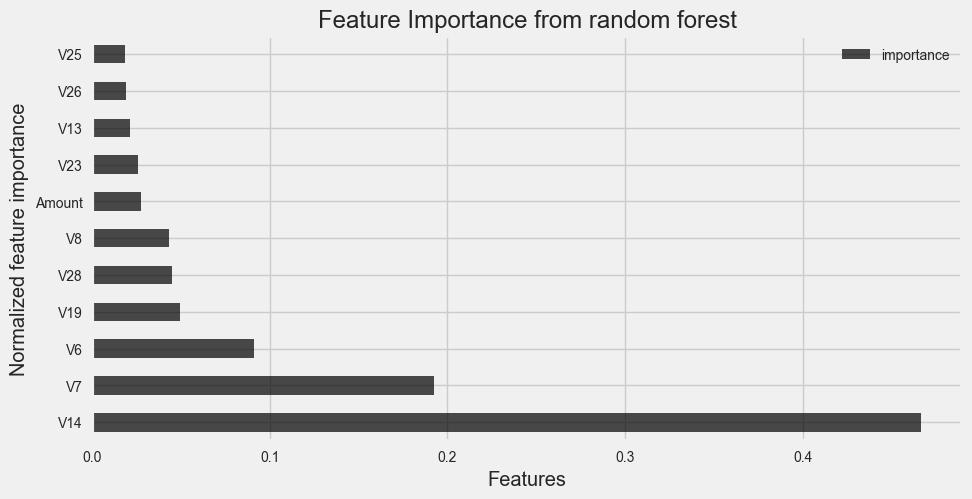

In [47]:
# Bar plot

# Plot styling
plt.style.use("fivethirtyeight")
plt.rcParams["font.size"] = 12

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)

(feature_results
     .sort_values("importance", ascending=False)
     .set_index("feature")
     .plot.barh(
         ax=ax,
         color='k',
         alpha=0.7,
         title="Feature Importance from random forest",
         ylabel="Normalized feature importance",
         xlabel="Features"         
     ))

**V14 accounts for close to half of the normalized feature importance, just from the top 3 features alone (V14, V7, and V6), we already account for 3/4 of the feature importance. I might get a more parsimonious model just by training with the top 3 features alone.** 

### Confusion Matrix
- Use the full train set to perform K-fold CV (e.g., split train set into 5 folds). Use 1 fold to test, and the remaining folds to train.
- If I use cross_val_predict(), each "test" fold is used to generate "clean predictions". Meaning that the predictions were generated from a model that never saw the test data during training.
- I repeat this for all test folds to get a set clean predictions (has the same sample size as the train set).

In [48]:
y_train_pred = cross_val_predict(
    estimator = rf_grid_search_best_pipeline,
    X = X_train,
    y = y_train,
    cv = skf
)

In [49]:
# I have a set of clean predictions in y_train_pred
y_train_pred.shape, y_train.shape 

((227845,), (227845,))

In [50]:
# Confusion matrix
cm = confusion_matrix(y_train, y_train_pred)
cm

array([[227202,    249],
       [    65,    329]])

**Plot confusion matrix in a heatmap**

In [51]:
def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[227202    249]
 [    65    329]]


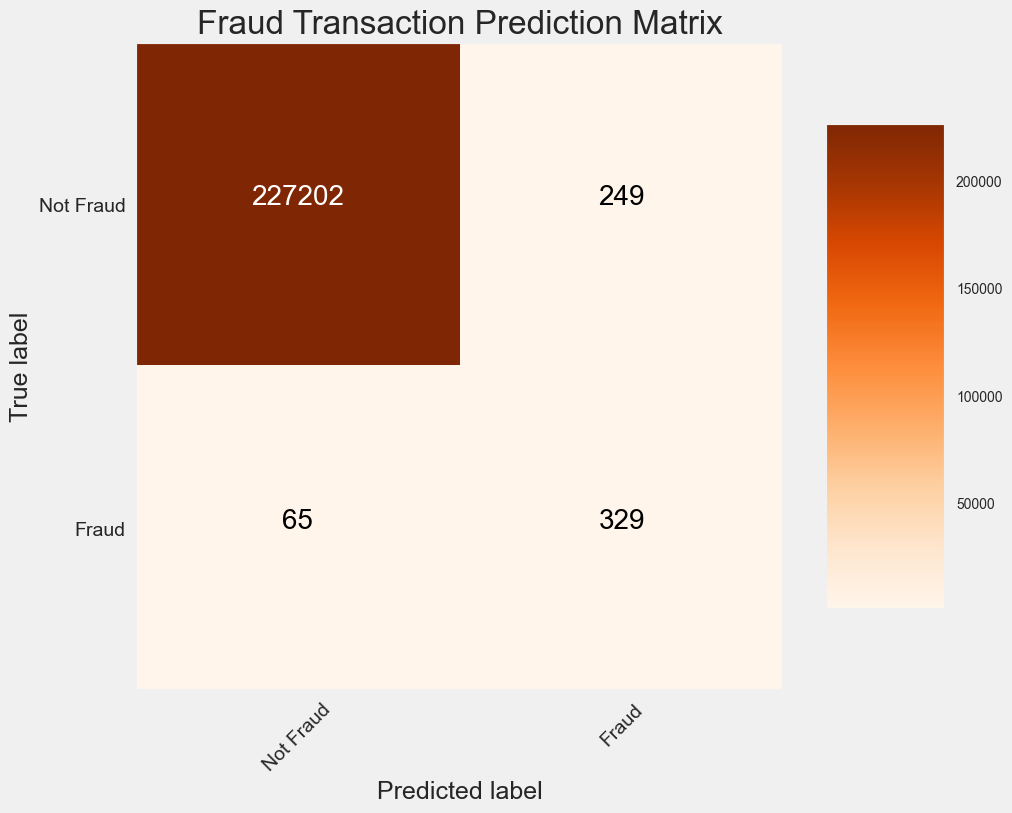

In [52]:
plot_confusion_matrix(cm = cm, 
                      classes = ['Not Fraud', 'Fraud'],
                      normalize=False,
                      title = 'Fraud Transaction Prediction Matrix')

**The model makes 578 Fraud predictions, of which, 329 (0.57) are actually Fraud transactions. The precision of the model is 0.57. But I am less concern about this since the 249 False positive cases will be investigated by human analysts. Of the 394 actual fraud cases, the model correctly predicts 329 (0.84). Therefore, reacall is 0.84 and I only have 65 False negatives. I am more concerned about the recall score since I want to detect as much fraud transactions as possible. The cost of False Negative is much higher than that of False Positives. Resampling using SMOTE enable us to train a model that performs well in predicting the minority (but the more interesting) Fraud class!**


### Precision and Recall curve

As a rule of thumb, you should use AUPRC whenever the positive class is rare (as in our case) or when you care more about the false positives than the false negatives. Otherwise, we use AUROC.
If I set my threshold to a high value, say 0.8, the classifier will make less positive predictions. In this case, its precision will increase, but its recall will decrease. The inverse is true if the threshold is low (e.g., 0.3).

A NOTE about the average_precision score for multiclass classification

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html
sklearn.metrics.average_precision_score(y_true, y_score, *, average='macro', pos_label=1, sample_weight=None)
If average is set to None then the scores for each class are returned. Otherwise, this argument determines the type of averaging performed on the data: "micro", "macro", "weighted", "sample"
average will be ignored if outcome is binary

In [53]:

def plot_multiclass_prc(
    y_val: pd.Series,
    y_scores: pd.Series,
    mapping: Dict,
    out_path: Union[str, Path],
    figsize: tuple[int, int] = (15, 8),
):
    """plot_multiclass_prc

    Args:
        y_val (pd.Series): true values of DV
        y_scores (pd.Series): probability
        estimation of DV
        mapping (Dict): mapping dictionary of
        numeric encoding of DV to its string encoding
        out_path (Union[str, Path]): output
        path of the saved PRC png figure
        figsize (tuple[int, int], optional): Size of
        PRC figure. Defaults to (15, 8).
    """

    # structures
    precisions = dict()
    recalls = dict()
    auprcs = dict()

    # get dummy variables for y_val, one for each level
    y_val_dummies = pd.get_dummies(y_val, drop_first=False).values

    # Compute precision, recall for each class
    # Also compute the AUPRC for each class
    for k, v in mapping.items():
        precisions[v], recalls[v], _ = precision_recall_curve(
            y_val_dummies[:, k - 1], y_scores[:, k - 1]
        )
        auprcs[v] = average_precision_score(y_val_dummies[:, k - 1], y_scores[:, k - 1])

    # plot precision and recall vs threshold for each class
    fig, ax = plt.subplots(figsize=figsize)
    plt.style.use("fivethirtyeight")
    plt.rcParams["font.size"] = 12

    for k, v in mapping.items():
        ax.plot(
            recalls[v],
            precisions[v],
            label=f"PRC for class {v} (area = {round(auprcs[v],2)}"
            + f" vs prop of class: {round(y_val_dummies[:, k - 1].mean(),2)})",
        )
    # Plot settings
    ax.set_xlim([0.0, 1.0])  # set x and y limits
    ax.set_ylim([0.0, 1.05])

    ax.set_xlabel("Recall")  # set x and y labels and title
    ax.set_ylabel("Precision")
    ax.set_title("Precision and Recall Curves")

    ax.legend(loc="best")
    # plt.show()
    plt.savefig(out_path, dpi=300, bbox_inches="tight")


In [54]:
y_train_pred_scores = cross_val_predict(
    estimator = rf_grid_search_best_pipeline,
    X = X_train,
    y = y_train,
    cv = skf,
    method = "predict_proba"
)

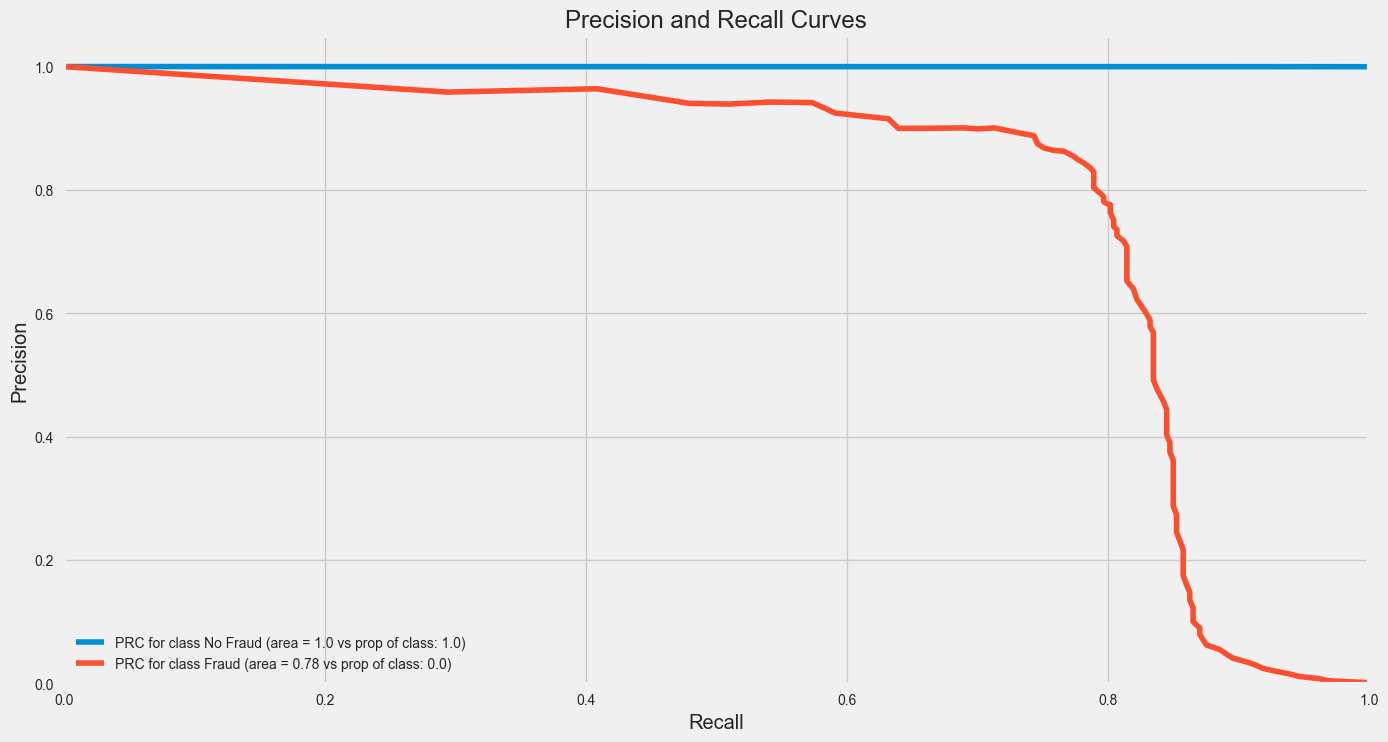

In [55]:
plot_multiclass_prc(y_val = y_train, 
                    y_scores = y_train_pred_scores, 
                    mapping = {1:"No Fraud", 2:"Fraud"},
                    out_path = Path("outputs"))

**The AURPC (average precision) of Fraud Class is 0.78, relative to `random guess` (baseline) of ~0.0.**

## Evaluating the optimized Random Forest model using the test (hold-out) set

In [56]:
X_test.shape, y_test.shape

((56962, 11), (56962,))

In [57]:
y_test_pred = rf_grid_search_best_pipeline.predict(X_test)

In [58]:
# I have a set of predictions in y_test_pred from the test set (X_test)
y_test_pred.shape, y_test.shape 

((56962,), (56962,))

In [59]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
cm

array([[56800,    64],
       [   18,    80]])

Confusion matrix, without normalization
[[56800    64]
 [   18    80]]


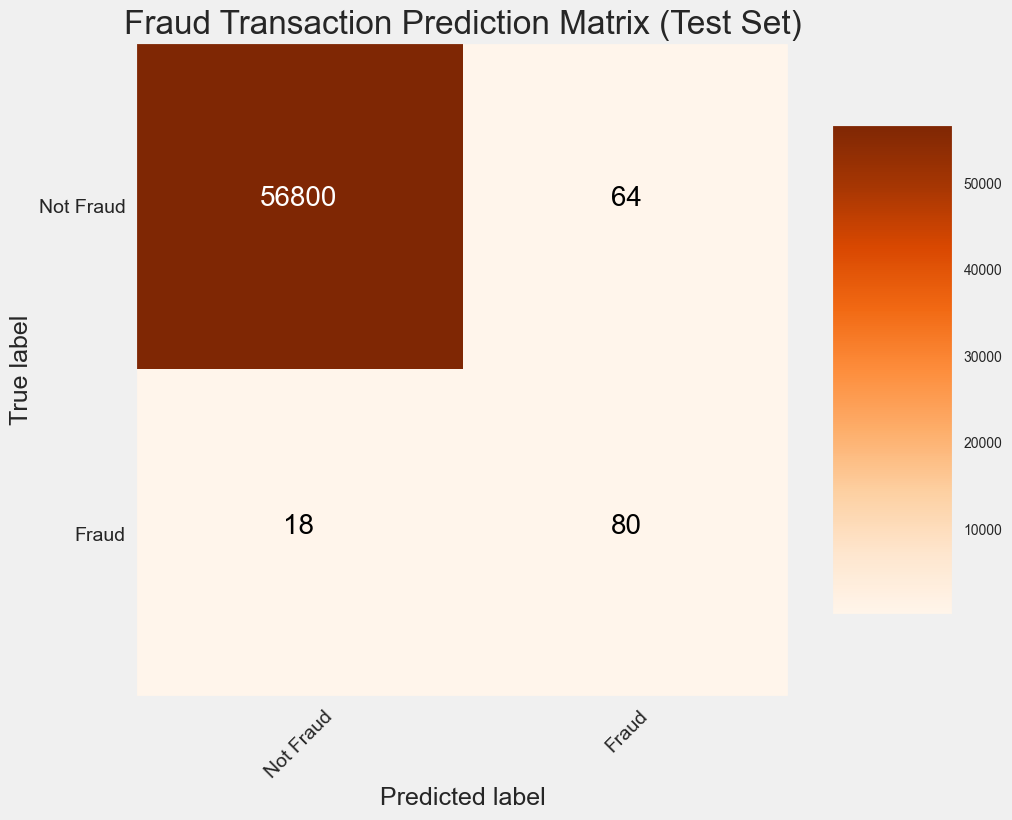

In [60]:
plot_confusion_matrix(cm = cm, 
                      classes = ['Not Fraud', 'Fraud'],
                      normalize=False,
                      title = 'Fraud Transaction Prediction Matrix (Test Set)')

**Of the 98 Fraud cases in the hold out set, the model correctly predict 80 (0.816) of them. Thus, the recall score is 0.816.**

In [61]:
y_test_pred_scores = rf_grid_search_best_pipeline.predict_proba(X_test)

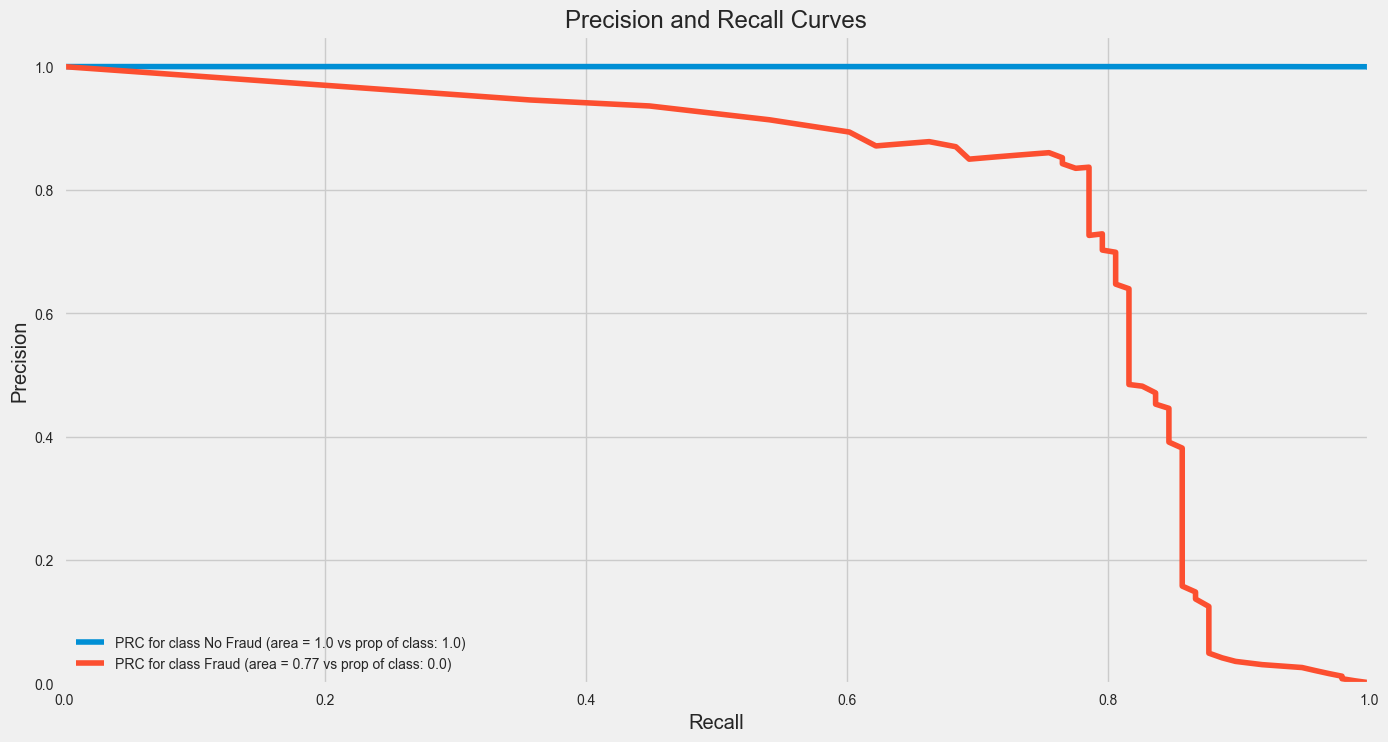

In [62]:
plot_multiclass_prc(y_val = y_test, 
                    y_scores = y_test_pred_scores, 
                    mapping = {1:"No Fraud", 2:"Fraud"},
                    out_path = Path("outputs"))

**The average precision score (AUPRC) from test set is 0.77, relative to the baseline of 0.0**

In [70]:
f1_score(y_test, y_test_pred)

0.6611570247933884

In [68]:
np.unique(y_test_pred, return_counts=True)[1][1]

144

In [69]:
len(y_test_pred)

56962